In [30]:
import numpy as np                  # Data
import pandas as pd                 # Data
import matplotlib.pyplot as plt     # Plot
import matplotlib.lines as mlines   # Plot

Use Latex Font

In [31]:
plt.rcParams.update({
    "text.usetex": True,                # Use LaTeX for text
    "font.family": "serif",             # Use 'serif' font
    "font.serif": ["Computer Modern"],  # LaTeX default font
    "font.size": 11,                    # General font size
    "axes.labelsize": 11,               # Font size for labels
    "legend.fontsize": 11,              # Font size for legend
    "xtick.labelsize": 10,              # Font size for x-axis
    "ytick.labelsize": 10               # Font size for y-axis
})  

# Methodology

In [32]:
def identify_drought(time_series: pd.Series,threshold:float):
    events_thresh = time_series<threshold
    raw_events = events_thresh.groupby(events_thresh.ne(events_thresh.shift()).cumsum()).cumsum()
    identified_events = raw_events[(raw_events.shift(1) < raw_events) & (raw_events.shift(-1) < raw_events)]
    identified_events.index = pd.Index([date - pd.Timedelta(identified_events.loc[date]-1, unit='h') for date in identified_events.index])
    return identified_events

In [33]:
df_combine = pd.read_csv('../Data/cf_combine_7923.csv',
                         index_col=0,
                         parse_dates=True
)

df_combine_avg = df_combine.rolling('D', min_periods=24, center=True).mean()

In [34]:
droughts_dict = {}

for column in df_combine_avg:
    raw_droughts = identify_drought(df_combine_avg[column], 0.15)
    droughts = raw_droughts[raw_droughts > 24]
    droughts_df = pd.DataFrame(droughts)
    droughts_df = droughts_df.set_axis(['Duration'], axis=1)
    droughts_dict[column] = droughts_df

In [35]:
df_flags = pd.DataFrame(index=df_combine_avg.index)

for col in df_combine_avg:
    series = df_combine_avg[col]
    new_series = pd.Series(0, index=series.index)
    count = 0
    for i in range(len(series)):
        if series.iloc[i] < 0.1:
            count += 1
        else:
            if count > 24:
                new_series.iloc[i-count:i] = 1
            count = 0
    if count > 24:
        new_series.iloc[len(series)-count:len(series)] = 1
    df_flags[col] = new_series

# Plots

In [36]:
def my_title(ax, title, fs = 12):
    ax.set_title(title, 
                 x=0.5, y=1,
                 pad = -14,
                 fontsize=fs, 
                 bbox=dict(facecolor='white', alpha=1, edgecolor='white'))

In [37]:
label_name = ['Atlite', 'C3S-E G', 'C3S-E N']
title_name = ['a) Wind', 'b) PV', 'c) Existing', 'd) Balanced']
color_models = ['#B03024', '#348ABD', '#988ED5']
sign_models = [':', '--', '-']

In [38]:
# Group datasets based on categories
categories = {
    'onshorewind': ['onshorewind_atlite', 'onshorewind_c3se_gridded', 'onshorewind_c3se_national'],
    'pv': ['pv_atlite', 'pv_c3se_gridded', 'pv_c3se_national'],
    'combine_2023': ['combine_atlite_2023', 'combine_c3se_gridded_2023', 'combine_c3se_national_2023'],
    'combine_2030': ['combine_atlite_2030', 'combine_c3se_gridded_2030', 'combine_c3se_national_2030']
}

In [77]:
# Define days in months
dim = np.array([31, 28.25, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

# Define the order of the months for plotting
months = np.arange(12)
month_labels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']

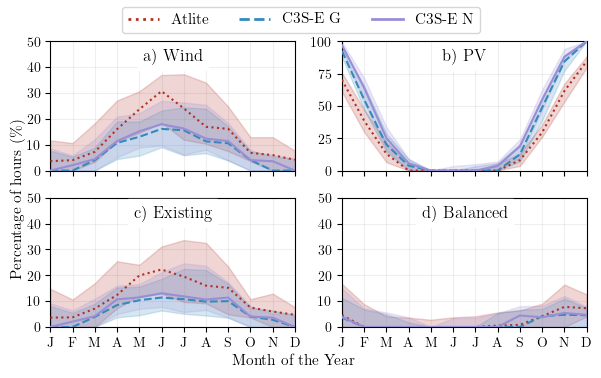

In [84]:
# Create subplots
cm = 1/2.54
fig, axs = plt.subplots(2, 2, 
                        figsize=(16*cm, 10*cm), 
                        sharex=True)
axs = axs.flatten()

# Loop over categories
for idx, (category, datasets_in_category) in enumerate(categories.items()):
    ax = axs[idx]

    # Loop over datasets in category
    for i, name in enumerate(datasets_in_category):

        # Select data
        df = df_flags[name]

        # Calculate Annual reduction for Article and print
        mean_year = df.resample('Y').mean() * 100
        annual_median = mean_year.median()

        # Calculate 
        df_resam = df.resample('M').mean() * 100
        monthly_event_median = df_resam.groupby(df_resam.index.month).median() 
        monthly_event_q1 = df_resam.groupby(df_resam.index.month).quantile(0.25) 
        monthly_event_q3 = df_resam.groupby(df_resam.index.month).quantile(0.75) 

        # Plot lines
        ax.plot(months, monthly_event_median,
                color = color_models[i],
                ls = sign_models[i],
                zorder=3
        )

        # Plot shaded area
        ax.fill_between(months, monthly_event_q1, monthly_event_q3,
                color = color_models[i],
                zorder=2,
                alpha=0.2
        )
    my_title(ax, title_name[idx])
    ax.grid(True, alpha=0.2, zorder=-2)
    # ax.margins(0.02)

    # x-axis
    ax.set_xlim(0, 11, auto=True)
    ax.set_xticks(months[::1])  # Select every other month
    ax.set_xticklabels([month_labels[m] for m in months[::1]], fontsize = 10)  # Customize labels

    #y-axis
    if idx == 1:
        ax.set_ylim(0,100)
    else:
        ax.set_ylim(0,50)
        ax.set_yticks(range(0, 51, 10))

handles = [mlines.Line2D([], [], color=color_models[i], lw=2, ls = sign_models[i], label=label_name[i]) for i in range(len(color_models))]
fig.legend(handles = handles,
           loc = 'upper center',
           ncol = 3,
           markerscale = 2,
           fontsize = 11)

fig.supxlabel('Month of the Year', y = 0.07, fontsize = 11)
fig.supylabel('Percentage of hours (\%)', x = 0.05, fontsize = 11)

fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.savefig('droughts_seasonality.pdf', bbox_inches='tight')

Calculate Number in Article

In [41]:
for idx, (category, datasets_in_category) in enumerate(categories.items()):
    for i, name in enumerate(datasets_in_category):
        print(name, df_flags[name].sum() / df_flags[name].shape)

onshorewind_atlite [0.15535258]
onshorewind_c3se_gridded [0.09348382]
onshorewind_c3se_national [0.1041616]
pv_atlite [0.26239403]
pv_c3se_gridded [0.35600714]
pv_c3se_national [0.38241259]
combine_atlite_2023 [0.13649408]
combine_c3se_gridded_2023 [0.08285167]
combine_c3se_national_2023 [0.09245964]
combine_atlite_2030 [0.0493353]
combine_c3se_gridded_2030 [0.03469518]
combine_c3se_national_2030 [0.04047264]
